In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

####### Fixing Seed #######
random_seed=2
np.random.seed(random_seed)
###########################

%config InlineBackend.figure_format = 'retina'

In [2]:
values1 = np.round(np.arange(-.11,.1,.02)+.01,2)
print(values1, len(values1))

values2 = np.round(np.arange(-.22,.2,.04) +.02,2)
print(values2, len(values2))

[-0.1  -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1 ] 11
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2 ] 11


In [3]:
B=250
n_p=250 #number of simulations used to estimate power
alpha=.05
perc=list(range(20,100,20)) #percentiles for binning
n=5000
test=.5

# Label & Conc. 1 

In [4]:
d=3
task='class'

## Label shift

In [5]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in [0]:
        for delta in values1:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            
        
            ### Ztest ###
            pval_z=ztest(ys, yt)
            
            ### TV ###
            labelshift=tv(ys, yt)
            y = np.hstack((ys, yt))
            labelperm = []
            for b in range(B):
                shuffle = np.random.choice(range(y.shape[0]), size=(y.shape[0],), replace=False)
                inds = shuffle[:ys.shape[0]]
                indt = shuffle[ys.shape[0]:]
                labelperm.append(tv(y[inds],y[indt]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            labelperm=np.array(labelperm)
            labelperm=labelperm+np.random.normal(0,s,labelperm.shape[0])
            labelshift=labelshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(labelperm) >= labelshift))/(B+1)
            
            
            ### Ours ###
            lab=PermutDiscrete(get_dummies(ys), get_dummies(yt), B=B, verbose=False)
            pval_kl = lab['pval']
 
            ### Output ###
            pvals.append([delta, pval_z, pval_tv, pval_kl])

100%|██████████| 250/250 [25:19<00:00,  6.08s/it]


In [6]:
pvals=np.array(pvals)
pvals[:,1:]=pvals[:,1:]<alpha
powerlab=np.zeros((len(values1),4))

for i in range(len(values1)):
    powerlab[i,0]=values1[i]
    powerlab[i,1:]=np.mean(pvals[pvals[:,0]==values1[i],1:],axis=0)

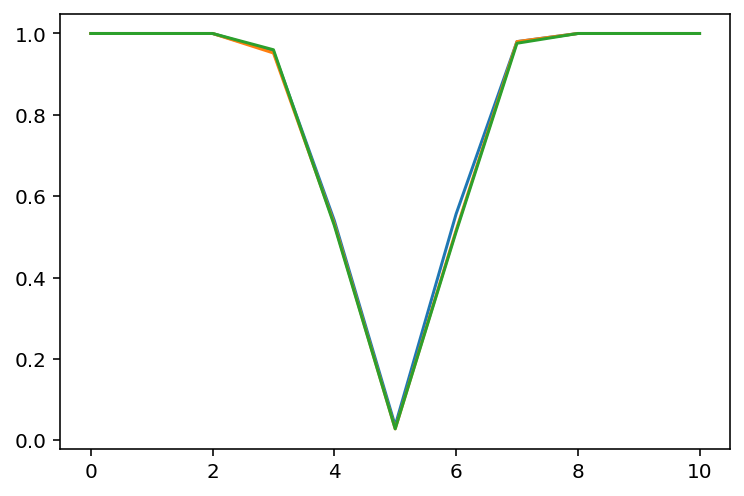

In [7]:
plt.plot(powerlab[:,1])
plt.plot(powerlab[:,2])
plt.plot(powerlab[:,3])

## Conc shift 1

In [8]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in values1:
        for delta in [0]:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            

            ### TV
            Xbins = np.percentile(np.vstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            
            df = pd.DataFrame(Xs_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2]
            Xs_bin=np.array(df['concat'], dtype='int')
            
            df = pd.DataFrame(Xt_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2] 
            Xt_bin=np.array(df['concat'], dtype='int')
            
            y = np.hstack((ys,yt))
            X_bin = np.hstack((Xs_bin,Xt_bin))
            
            concshift=tv_conc(ys,Xs_bin,yt,Xt_bin)
            concperm = []
            Y=np.unique(np.array(y))
            ind={}
            for j in Y:
                ind[j] = (np.array(y)==j).squeeze()

            for b in range(B):
                X_perm = np.zeros(X_bin.shape)
                shuffle={}
                for j in Y:
                    shuffle[j] = np.random.choice(range(np.sum(ind[j])), size=(np.sum(ind[j]),), replace=False)
                    X_perm[ind[j]] = X_bin[ind[j]][shuffle[j]]

                concperm.append(tv_conc(ys,X_perm[:Xs_bin.shape[0]],yt,X_perm[Xs_bin.shape[0]:]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)

            conc1=LocalPermut(Xs_test, ys_test, Xt_test, yt_test, 
                              totshift_model, labshift_model=None, task=task, B=B, verbose=False)
        
            pval_kl = conc1['pval']
 

            ### Output ###
            pvals.append([gamma, pval_tv, pval_kl])

100%|██████████| 250/250 [5:45:25<00:00, 82.90s/it]    


In [9]:
pvals=np.array(pvals)
pvals[:,1:]=pvals[:,1:]<alpha
powerconc1=np.zeros((len(values1),3))

for i in range(len(values1)):
    powerconc1[i,0]=values1[i]
    powerconc1[i,1:]=np.mean(pvals[pvals[:,0]==values1[i],1:],axis=0)

# Cov. & Conc. 2 shifts

In [10]:
task='reg'

## Cov. shift

In [11]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in [0]:
        for lamb in values2:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            Xs, ys, Xt, yt = Xs.squeeze(), ys.squeeze(), Xt.squeeze(), yt.squeeze()
            
            ### KS ###
            pval_ks=list(stats.ks_2samp(Xs,Xt))[1]
            
            ### TV ###
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)

            covshift=tv(Xs_bin,Xt_bin)
            X_bin = np.hstack((Xs_bin,Xt_bin))
            covperm = []
            for b in range(B):
                shuffle = np.random.choice(range(X_bin.shape[0]), size=(X_bin.shape[0],), replace=False)
                inds = shuffle[:Xs_bin.shape[0]]
                indt = shuffle[Xs_bin.shape[0]:]
                covperm.append(tv(X_bin[inds],X_bin[indt]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            covperm=np.array(covperm)
            covperm=covperm+np.random.normal(0,s,covperm.shape[0])
            covshift=covshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(covperm) >= covshift))/(B+1)
            
            
            ### Ours ###
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)
            
            cov=Permut(Xs_test, Xt_test, covshift_model, B=B, verbose=False)
            pval_kl = cov['pval']
            
            ### Output ###
            pvals.append([lamb, pval_ks, pval_tv, pval_kl])

100%|██████████| 250/250 [18:37<00:00,  4.47s/it]


In [12]:
pvals=np.array(pvals)
pvals[:,1:]=pvals[:,1:]<alpha
powercov=np.zeros((len(values2),4))

for i in range(len(values2)):
    powercov[i,0]=values2[i]
    powercov[i,1:]=np.mean(pvals[pvals[:,0]==values2[i],1:],axis=0)

## Conc shift 2

In [13]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in values2:
        for lamb in [0]:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)

            # Training CDE
            cd_model = cde_reg(boost=False, cv=None)
            cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                         pd.concat([ys_train, yt_train], axis=0))
            
            ### TV ###
            #(we use only the test set because we used the training set to train the cde)
            Xs, ys, Xt, yt = Xs_test.squeeze(), ys_test.squeeze(), Xt_test.squeeze(), yt_test.squeeze()
            
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            ybins = np.percentile(np.hstack((ys,yt)), q=perc)
            ys_bin, yt_bin = np.digitize(ys, ybins), np.digitize(yt, ybins)
            
            concshift=tv_conc(Xs_bin,ys_bin,Xt_bin,yt_bin)
            concperm = []

            for b in range(B):
                ys_hat, yt_hat = cd_model.sample(Xs_test), cd_model.sample(Xt_test)
                ybins = np.percentile(np.hstack((ys_hat,yt_hat)), q=perc)
                ys_bin_hat, yt_bin_hat = np.digitize(ys_hat, ybins), np.digitize(yt_hat, ybins)
                concperm.append(tv_conc(Xs_bin,ys_bin_hat,Xt_bin,yt_bin_hat))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)

            ###
            conc2=CondRand(Xs_test, ys_test, Xt_test, yt_test, 
                           cd_model, totshift_model, covshift_model, B=B, verbose=False)
            
            pval_kl = conc2['pval']
            
            ### Output ###
            pvals.append([theta, pval_tv, pval_kl])

100%|██████████| 250/250 [57:33<00:00, 13.81s/it]


In [14]:
pvals=np.array(pvals)
pvals[:,1:]=pvals[:,1:]<alpha
powerconc2=np.zeros((len(values2),3))

for i in range(len(values2)):
    powerconc2[i,0]=values2[i]
    powerconc2[i,1:]=np.mean(pvals[pvals[:,0]==values2[i],1:],axis=0)

# Saving

In [15]:
np.save('outputs/powerlab.npy', powerlab)
np.save('outputs/powercov.npy', powercov)
np.save('outputs/powerconc1.npy', powerconc1)
np.save('outputs/powerconc2.npy', powerconc2)

# Plots

In [16]:
powerlab=np.load('outputs/powerlab.npy')
powercov=np.load('outputs/powercov.npy')
powerconc1=np.load('outputs/powerconc1.npy')
powerconc2=np.load('outputs/powerconc2.npy')

In [17]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.05   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

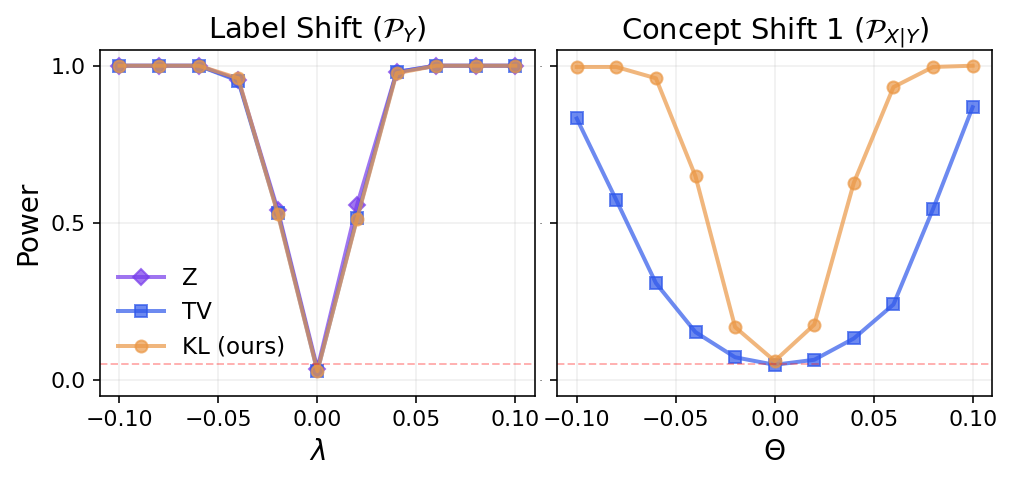

In [18]:
plt.figure(figsize=(8,3))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 2, 1)
names=['Z','TV','KL (ours)']
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080'] 
plt.plot(powerlab[:,0],powerlab[:,1], color=colors[1], marker="D", lw=2, label=names[0], alpha=.7, markersize=6)
plt.plot(powerlab[:,0],powerlab[:,2], color=colors[0], marker="s", lw=2, label=names[1], alpha=.7, markersize=6)
plt.plot(powerlab[:,0],powerlab[:,3], color=colors[3], marker="o", lw=2, label=names[2], alpha=.7, markersize=6)
plt.legend(bbox_to_anchor=(.02, .4), loc='upper left', ncol = 1, prop={'size': 11.5}, borderaxespad=.0, frameon=False)       
plt.grid(alpha=.2)
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.3)
plt.ylabel('Power', size=14)
plt.ylim([-0.05,1.05])
plt.xlabel("$\lambda$", size=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.locator_params(axis="y", nbins=4)
plt.title("Label Shift $(\mathcal{P}_{Y})$",size=14.5)

plt.subplot(1, 2, 2)
names=['TV','KL (ours)']
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080']
plt.plot(powerconc1[:,0],powerconc1[:,1], color=colors[0], marker="s", lw=2, label=names[0], alpha=.7, markersize=6)
plt.plot(powerconc1[:,0],powerconc1[:,2], color=colors[3], marker="o", lw=2, label=names[1], alpha=.7, markersize=6)
#plt.legend(bbox_to_anchor=(.015, .225), loc='upper left', ncol = 1, prop={'size': 11}, borderaxespad=.0, frameon=False)      
plt.grid(alpha=.2)
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.3)
#plt.ylabel('Power', size=13)
plt.ylim([-0.05,1.05])
plt.xticks(fontsize=11)
plt.yticks(fontsize=0)
plt.xlabel("$\Theta$", size=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.locator_params(axis="y", nbins=4)
plt.title("Concept Shift 1 $(\mathcal{P}_{X|Y})$",size=14.5)

plt.savefig('plots/competing_models1.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()


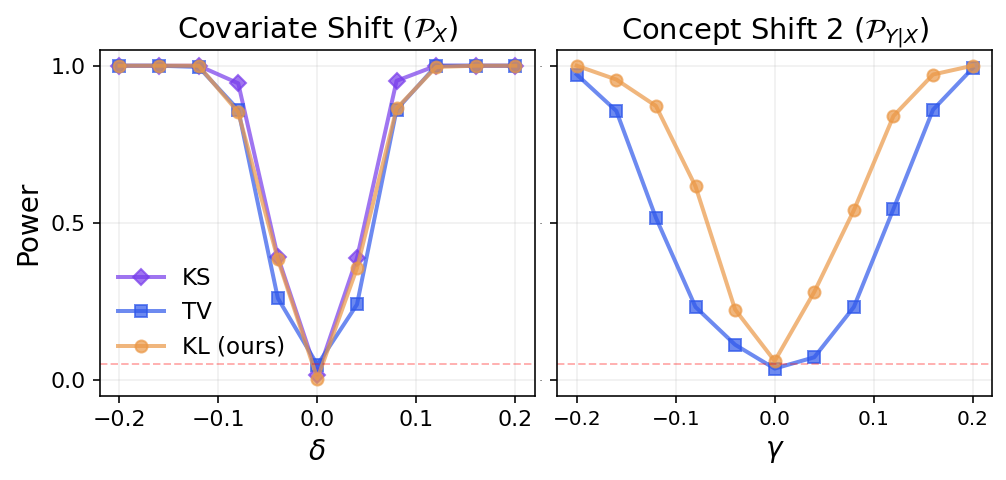

In [19]:
plt.figure(figsize=(8,3))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 2, 1)
names=['KS','TV','KL (ours)']
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080'] 
plt.plot(powercov[:,0],powercov[:,1], color=colors[1], marker="D", lw=2, label=names[0], alpha=.7, markersize=6)
plt.plot(powercov[:,0],powercov[:,2], color=colors[0], marker="s", lw=2, label=names[1], alpha=.7, markersize=6)
plt.plot(powercov[:,0],powercov[:,3], color=colors[3], marker="o", lw=2, label=names[2], alpha=.7, markersize=6)
plt.legend(bbox_to_anchor=(.02, .4), loc='upper left', ncol = 1, prop={'size': 11.5}, borderaxespad=.0, frameon=False)       
plt.grid(alpha=.2)
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.3)
plt.ylabel('Power', size=14)
plt.ylim([-0.05,1.05])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("$\delta$", size=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.locator_params(axis="y", nbins=4)
plt.title("Covariate Shift $(\mathcal{P}_{X})$",size=14.5)

plt.subplot(1, 2, 2)
names=['TV','KL (ours)']
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080']
plt.plot(powerconc2[:,0],powerconc2[:,1], color=colors[0], marker="s", lw=2, label=names[0], alpha=.7, markersize=6)
plt.plot(powerconc2[:,0],powerconc2[:,2], color=colors[3], marker="o", lw=2, label=names[1], alpha=.7, markersize=6)
#plt.legend(bbox_to_anchor=(.015, .225), loc='upper left', ncol = 1, prop={'size': 11}, borderaxespad=.0, frameon=False)      
plt.grid(alpha=.2)
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.3)
#plt.ylabel('Power', size=13)
plt.ylim([-0.05,1.05])
plt.yticks(fontsize=0)
plt.xlabel("$\gamma$", size=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.locator_params(axis="y", nbins=4)
plt.title("Concept Shift 2 $(\mathcal{P}_{Y|X})$",size=14.5)

plt.savefig('plots/competing_models2.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()